
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## HyCReeW runup estimation 

inputs required: 
  * Nearshore reconstructed historical storms
  * Historical water levels (daily high tides)

in this notebook:
  * HyCReWW runup estimation of historical data


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr
from scipy.interpolate import griddata
import matplotlib
import matplotlib.pyplot as plt
import utide 

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.rbf import RBF_Interpolation
from teslakit.mda import Normalize

from teslakit.plotting.extremes import Plot_ReturnPeriodValidation



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN')


# reef characteristics
reef_cs = {
    'rslope': 0.0505,
    'bslope': 0.1667,
    'rwidth': 250,
    'cf': 0.0105,
}


# load Hycreww RBF coefficients and sim. variables min. and max.
var_lims, rbf_coeffs = db.Load_HYCREWW()


In [32]:
# Load nearshore waves for 3 points at sections North, East & South
WVS_E = pd.read_pickle('/Users/albacid/Projects/TeslaKit_projects/inputs_Kwajalein/dataset_aggregated_E.pkl')
WVS_S = pd.read_pickle('/Users/albacid/Projects/TeslaKit_projects/inputs_Kwajalein/dataset_aggregated_S.pkl')

WVS_E = WVS_E.set_index('Time').to_xarray()
WVS_S = WVS_S.set_index('Time').to_xarray()
print(WVS_E)    
print()
    
    
# Load astronomical tide from TG
_, TIDE = db.Load_TIDE_hist()  # astronomical tide historical data
TIDE = TIDE.drop_vars('ntr')
TIDE = TIDE.drop_vars('sigma')
print(TIDE)

<xarray.Dataset>
Dimensions:  (Time: 111040)
Coordinates:
  * Time     (Time) datetime64[ns] 1979-01-01 ... 2016-12-31T21:00:00
Data variables:
    Hs       (Time) float64 2.93 3.128 3.092 3.072 ... 1.736 1.765 1.749 1.812
    Tp       (Time) float64 9.963 9.822 9.784 9.669 ... 8.451 8.553 8.559 8.471
    Dir      (Time) float64 73.08 75.26 76.35 76.83 ... 72.58 73.51 72.52 73.06

<xarray.Dataset>
Dimensions:    (time: 184104)
Coordinates:
  * time       (time) datetime64[ns] 1996-01-01 ... 2016-12-31T23:00:00.000002944
Data variables:
    observed   (time) float64 ...
    predicted  (time) float64 ...


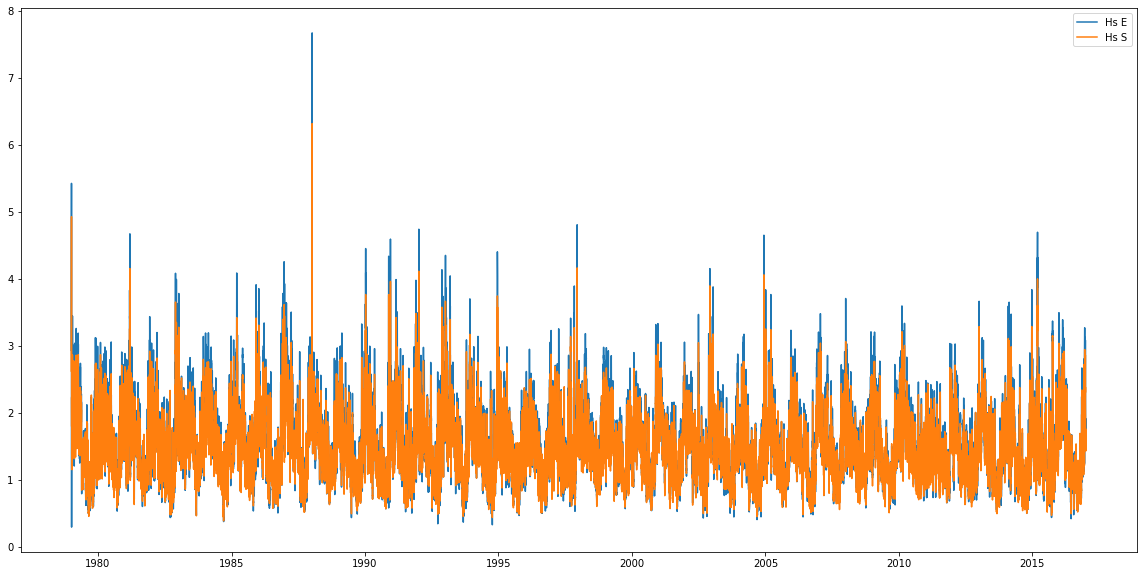

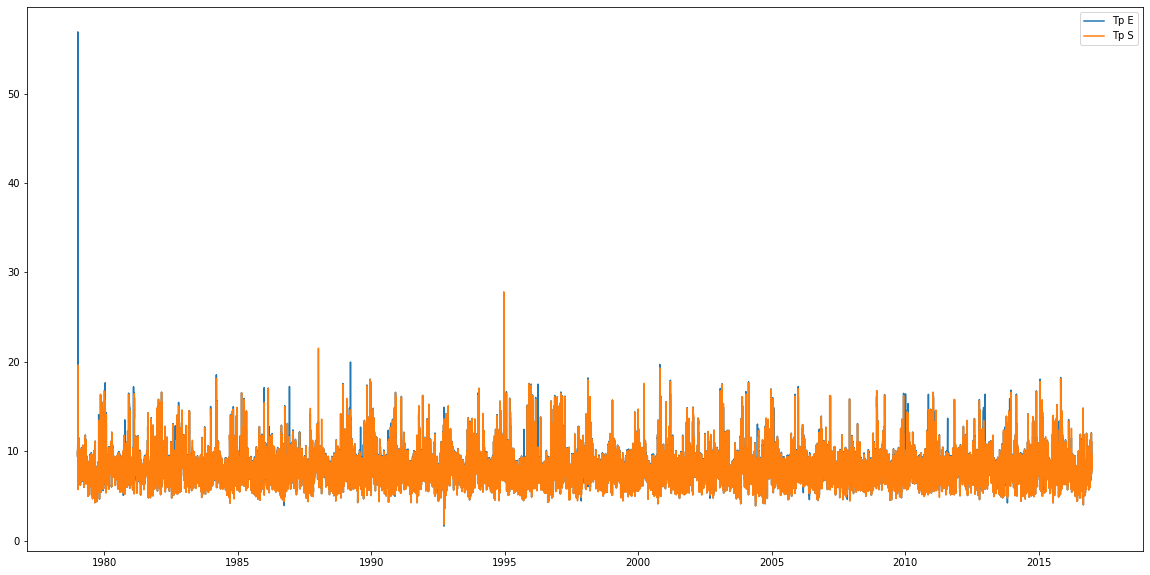

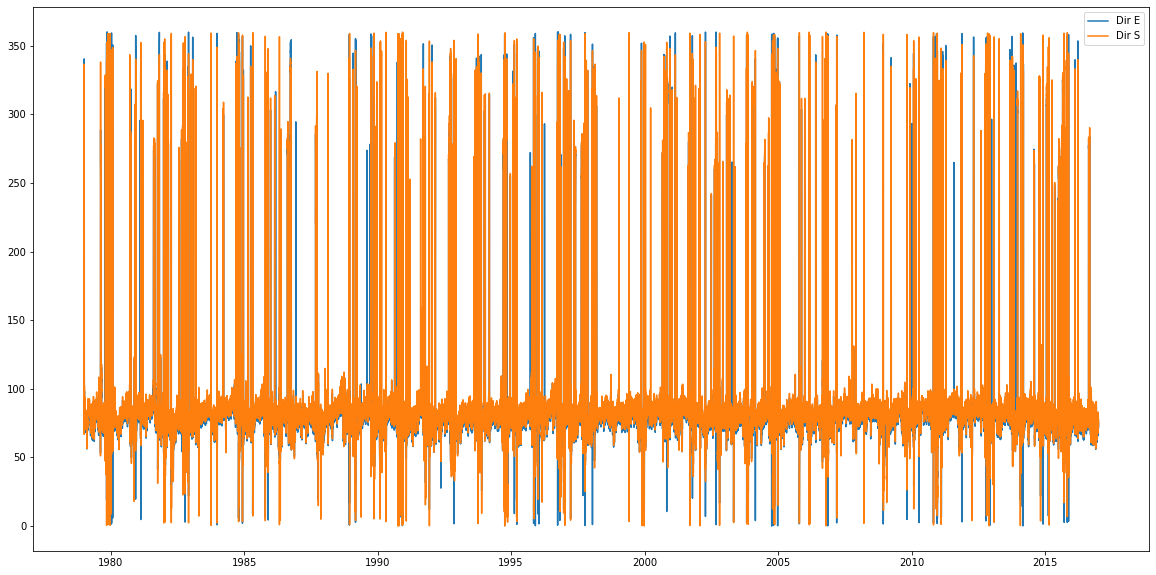

In [33]:
plt.figure(figsize=(20,10))
plt.plot(WVS_E.Time, WVS_E.Hs, label='Hs E')
plt.plot(WVS_S.Time, WVS_S.Hs, label='Hs S')
plt.legend()

plt.figure(figsize=(20,10))
plt.plot(WVS_E.Time, WVS_E.Tp, label='Tp E')
plt.plot(WVS_S.Time, WVS_S.Tp, label='Tp S')
plt.legend()

plt.figure(figsize=(20,10))
plt.plot(WVS_E.Time, WVS_E.Dir, label='Dir E')
plt.plot(WVS_S.Time, WVS_S.Dir, label='Dir S')
plt.legend()

## Obtain base level for Hycreww (daily high tide)

solve: matrix prep ... solution ... diagnostics ... done.
prep/calcs ... done.
<xarray.Dataset>
Dimensions:  (time: 111040)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2016-12-31T21:00:00
Data variables:
    AT       (time) float64 -0.8005 0.0776 0.9132 ... -0.1094 0.447 -0.1757


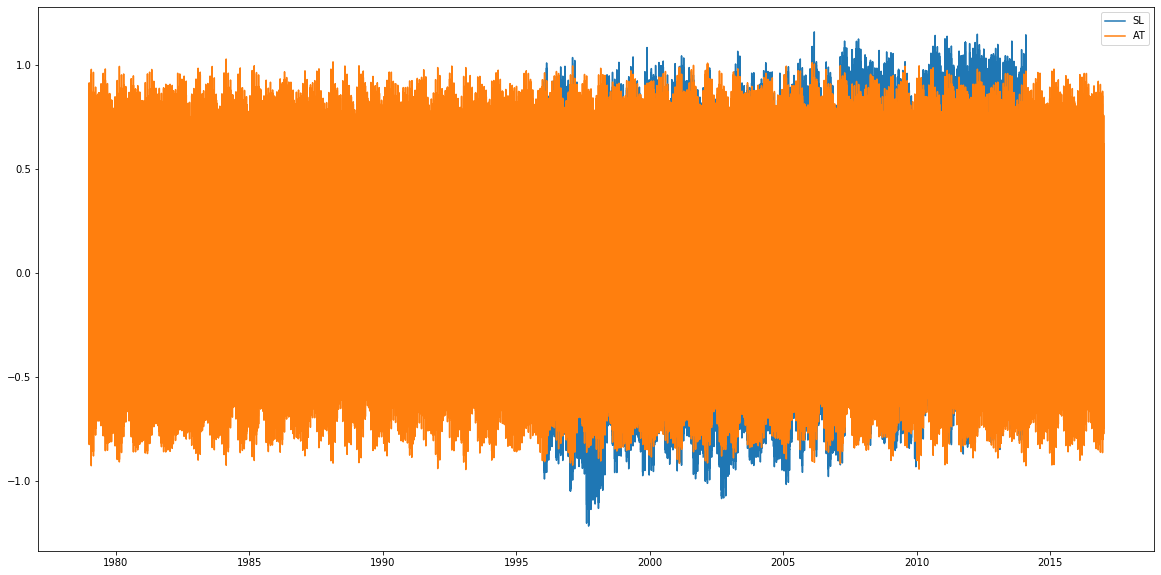

In [4]:
# --------------------------------------
# Obtain AT with Utide 
time = TIDE.time.values[:]
sl = TIDE.observed.values[:] - np.nanmean(TIDE.observed.values[:])
lat0 = 8.733

coef = utide.solve(
    matplotlib.dates.date2num(time), sl,
    lat=lat0,
    nodal=True,
    method='ols',
    conf_int='MC',
    trend=False
)

# Reconstruct AT for the Waves time period
at = utide.reconstruct(matplotlib.dates.date2num(WVS_E.Time.values[:]), coef).h

# Tide dataset
TIDE = xr.Dataset({'AT' :(('time',), at)}, {'time' : WVS_E.Time.values[:]})
print(TIDE)

plt.figure(figsize=(20,10))
plt.plot(time, sl, label='SL')
plt.plot(TIDE.time.values[:], TIDE.AT.values, label='AT')
plt.legend()
#ax = plt.gca()
#ax.set_xlim(735000-30, 735000)


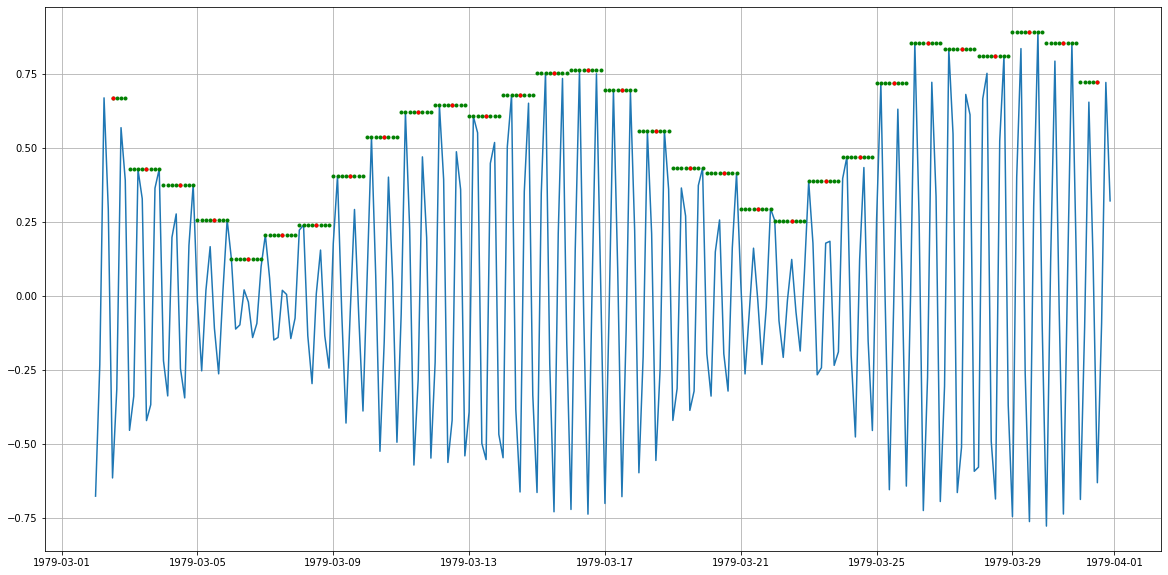

In [5]:
# para quitar:
TIDE_d = TIDE.isel(time=slice(20*24,30*24))

plt.figure(figsize=(20,10))
plt.plot(TIDE_d.time, TIDE_d.AT)

# Obtain max high tide within a day
TIDE_d = TIDE_d.resample(time='1D').max()
TIDE_d.coords['time'] = TIDE_d.time.values + np.timedelta64(12,'h')

# Resample to 3-h resolution (wave time resolution)
TIDE_3h = TIDE_d.resample(time='3H').nearest(tolerance="1D")

plt.plot(TIDE_3h.time, TIDE_3h.AT,'.g') # 3-H
plt.plot(TIDE_d.time, TIDE_d.AT,'.r') # daily 
plt.grid()


In [6]:
# Obtain max high tide within a day
TIDE = TIDE.resample(time='1D').max()
TIDE.coords['time'] = TIDE.time.values + np.timedelta64(12,'h')

# Resample to 3-h resolution (waves time resolution)
TIDE = TIDE.resample(time='3H').nearest(tolerance="1D")



## Hycreww RBF Interpolation: Historical

In [7]:
# hycreww interpolation 

def hycreww_runup(var_lims, rbf_coeffs, dset):
    '''
    Calculates RunUp using hycreww RBFs (level) and linear interpolation (Runup)
    
    var_lims   - hycreww variables min and max limits
    rbf_coeffs - hycreww rbf coefficients
    dset       - input dataset (pandas.DataFrame with "rbf_vns" columns)
    
    '''
    
    # RBF wave conditions 
    rbf_hs = [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5]
    rbf_hs_lo = [0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05 ]
    rbf_vns = ['level', 'rslope', 'bslope', 'rwidth', 'cf']
    
    # RBF parameters
    ix_sc = [0, 1, 2, 3, 4]
    ix_dr = []
    minis = [var_lims[x][0] for x in rbf_vns]
    maxis = [var_lims[x][1] for x in rbf_vns]
    
    
    # add reef characteristics
    for p in reef_cs.keys():
        dset[p] = reef_cs[p]

    # discard data outside limits
    for vn in var_lims.keys():
        dset = dset[(dset[vn] > var_lims[vn][0]) &(dset[vn] < var_lims[vn][1])]
    
    
    # RBF dataset to interpolate
    ds_in = dset[rbf_vns]

    # normalize data
    ds_nm ,_ ,_ = Normalize(ds_in.values, ix_sc, ix_dr, minis=minis, maxis=maxis)

    # RBF interpolation (with all cases?)
    ru_out = []
    for rc in rbf_coeffs:
        ro = RBF_Interpolation(rc['constant'], rc['coeff'], rc['nodes'], ds_nm.T)
        ru_out.append(ro)
    ru_z = np.array(ru_out)
    
    # RU Linear interpolation (hs, hs_lo -> runup)
    RU = []
    for c, (_, r) in enumerate(dset.iterrows()):
        vq = griddata((rbf_hs, rbf_hs_lo), ru_z[:,c], (r['hs'], r['hs_lo2']), method='linear')
        RU.append(vq)
    RU = np.array(RU)
    
    # store runup alongside input data
    dset_out = dset.copy()
    dset_out['runup'] = dset_out['level'] + RU

    return dset_out


In [8]:
# Load complete historical data and nearshore waves
#data = db.Load_HIST_Complete_daily() 
#waves = db.Load_NEARSHORE_RECONSTRUCTION_HIST_storms()

# valores coincidentes con la marea
WVS_E = WVS_E.sel(Time=slice('1979-01-01T12:00:00',' 2016-12-31T12:00:00'))
WVS_S = WVS_S.sel(Time=slice('1979-01-01T12:00:00',' 2016-12-31T12:00:00'))

WVS_E = WVS_E.rename({'Time': 'time'})
WVS_S = WVS_S.rename({'Time': 'time'})

WVS_E = WVS_E.rename_vars({"Hs": "hs", "Tp": "tp", 'Dir':'dir'})  # rename vars
WVS_S = WVS_S.rename_vars({"Hs": "hs", "Tp": "tp", 'Dir':'dir'})  # rename vars

WVS_E['hs_lo2'] = WVS_E['hs']/(1.5613*WVS_E['tp']**2)             # calc. hs_lo2
WVS_S['hs_lo2'] = WVS_S['hs']/(1.5613*WVS_S['tp']**2)             # calc. hs_lo2

WVS_E['level'] = TIDE.AT           # add level
WVS_S['level'] = TIDE.AT          # add level


<xarray.Dataset>
Dimensions:  (time: 111033)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T12:00:00 ... 2016-12-31T12:00:00
Data variables:
    hs       (time) float64 3.009 3.005 3.116 3.251 ... 1.563 1.532 1.641 1.736
    tp       (time) float64 9.655 9.642 9.549 9.379 ... 9.154 8.318 8.43 8.451
    dir      (time) float64 77.08 77.54 78.52 80.16 ... 74.8 71.31 71.4 72.58
    hs_lo2   (time) float64 0.02067 0.0207 0.02188 ... 0.01418 0.01479 0.01557
    level    (time) float64 0.9132 0.9132 0.9132 0.9132 ... 0.757 0.757 0.757


SystemExit: 

In [9]:
# calculate runup with hycreww
dset_E = WVS_E[['hs', 'tp', 'dir', 'level', 'hs_lo2']].to_dataframe()
out_hist_E = hycreww_runup(var_lims, rbf_coeffs, dset_E)

dset_S = WVS_S[['hs', 'tp', 'dir', 'level', 'hs_lo2']].to_dataframe()
out_hist_S = hycreww_runup(var_lims, rbf_coeffs, dset_S)

# store historical runup
#db.Save_NEARSHORE_RUNUP_HIST(out_hist)


In [10]:
print(out_hist_E)
print()
print(out_hist_S)


                           hs        tp        dir     level    hs_lo2  \
time                                                                     
1979-01-01 12:00:00  3.008752  9.655274  77.080916  0.913227  0.020671   
1979-01-01 15:00:00  3.004575  9.641858  77.540954  0.913227  0.020700   
1979-01-01 18:00:00  3.115778  9.549471  78.520308  0.913227  0.021884   
1979-01-01 21:00:00  3.251245  9.378521  80.160573  0.913227  0.023675   
1979-01-02 00:00:00  3.328059  9.423881  80.083289  0.748993  0.024002   
...                       ...       ...        ...       ...       ...   
2016-12-31 00:00:00  1.491209  8.149613  73.908606  0.757027  0.014381   
2016-12-31 03:00:00  1.563269  9.154227  74.804232  0.757027  0.011948   
2016-12-31 06:00:00  1.532325  8.318381  71.313182  0.757027  0.014184   
2016-12-31 09:00:00  1.640971  8.430071  71.397720  0.757027  0.014789   
2016-12-31 12:00:00  1.735770  8.450641  72.582997  0.757027  0.015568   

                     rslope  bslope  

(725365, 726095)

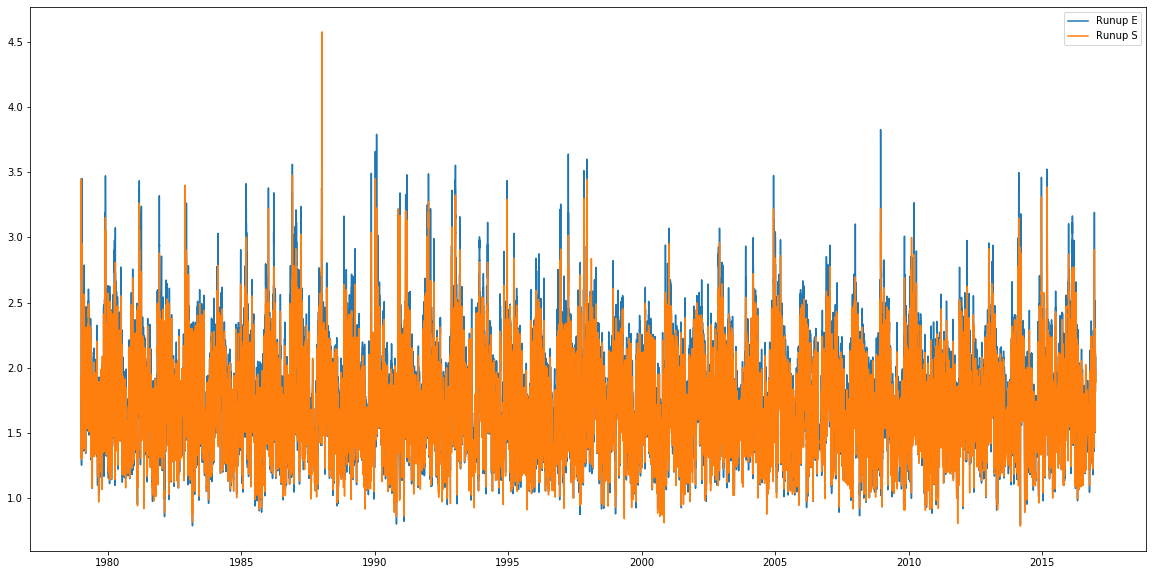

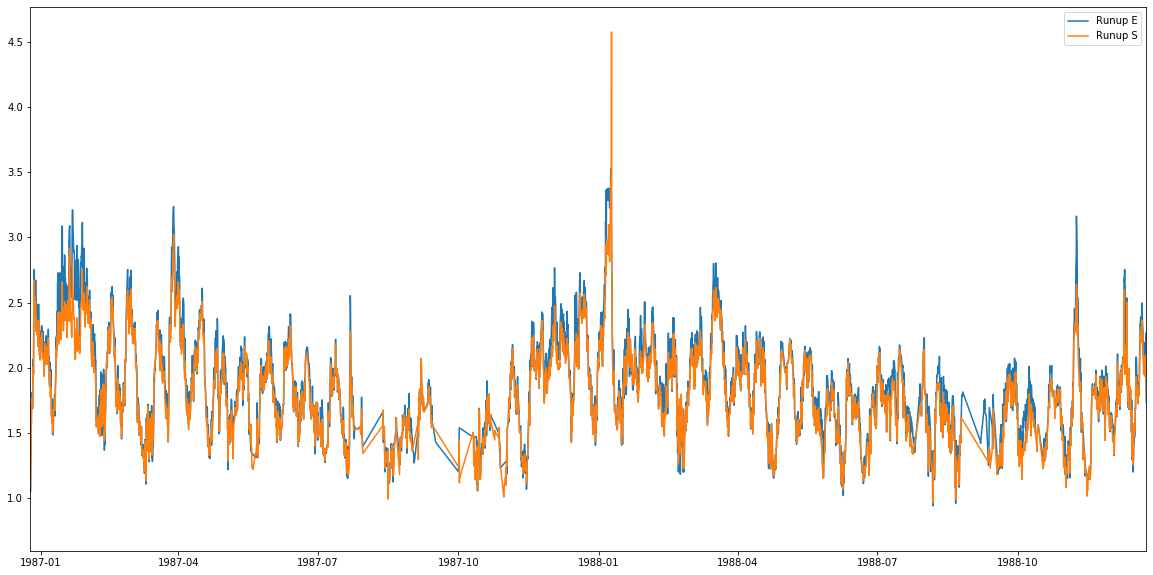

In [30]:
plt.figure(figsize=(20,10))
plt.plot(out_hist_E.runup, label='Runup E')
plt.plot(out_hist_S.runup, label='Runup S')
plt.legend()

plt.figure(figsize=(20,10))
plt.plot(out_hist_E.runup, label='Runup E')
plt.plot(out_hist_S.runup, label='Runup S')
plt.legend()
ax = plt.gca()
ax.set_xlim(725000+365, 725000+365*3)